## Performing Image Registration on segmentation masks and extracting transformmatrix


In [1]:
#%matplotlib notebook
import os
import pyelastix
from PIL import Image
import numpy as np 
import cv2
import json
import pydicom
import SimpleITK as sitk
from os import path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg


input_path ='./Masks/'
ref_path = './Reference/Reference_Mask.png'

## Functions

In [2]:
# creates a new folder if it does not already exist
def new_dir(dirName):
    try:
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

# target and reference are assumed numpy arrays of image files of the same resolution
def registration(target, reference, t):
    
    #internal elastix parameters
    params = pyelastix.get_default_params(type=t) #RIGID, AFFINE, BSPLINE
    params.NumberOfResolutions = 8
    params.AutomaticTransformInitialization = True
    params.AutomaticScalesEstimation = False
    params.NumberOfHistogramBins = 64
    params.MaximumStepLength = 4.0
    params.MaximumNumberOfIterations = 500

    registered, field = pyelastix.register(target, reference, params, verbose=0)
    return registered, field

def new_registration(target, reference, t):
    
    fixedImage = sitk.ReadImage(reference)
    movingImage = sitk.ReadImage(target)
    parameterMap = sitk.GetDefaultParameterMap(t)

    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()
    
    resultImage = elastixImageFilter.GetResultImage()
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()

    return resultImage, transformParameterMap
  

## Execution Pipeline 



### Affine Registrations with pyelastix

Directory  Pngs  already exists
Directory  Registered_with_PyElastix  already exists
Directory  Registered_Masks  already exists
Wall time: 1min 19s


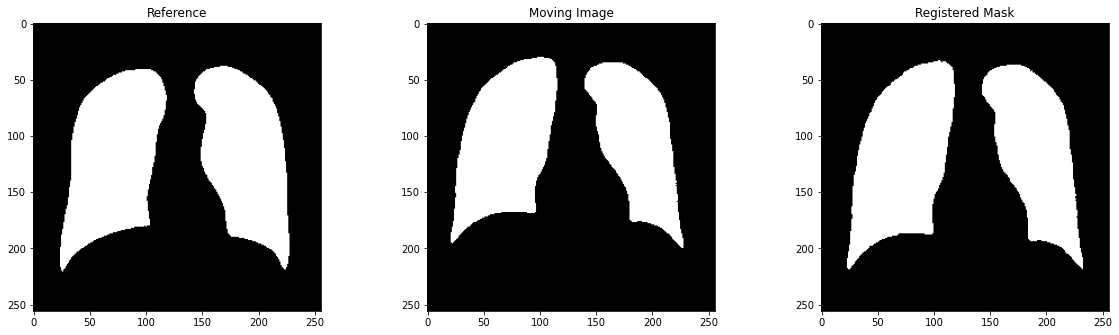

In [9]:
%%time
new_dir("Pngs")
new_dir("Registered_with_PyElastix")
new_dir("Registered_Masks")

reference = np.asarray(Image.open(ref_path)).astype(float)
filename = "test_file_1_Mask.png"
path = os.path.join(input_path, filename)
target = np.asarray(Image.open(path)).astype(float)
path2 = os.path.join('Registered_Masks', filename) 
r, f = registration(target, reference,"AFFINE")


ret, r = cv2.threshold(r, 120, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(20, 18))
plt.subplot(3, 3, 1)
plt.title('Reference')
plt.imshow(reference, cmap='gray')
plt.subplot(3, 3, 2)
plt.title('Moving Image')
plt.imshow(target, cmap='gray')
plt.subplot(3, 3, 3)
plt.title('Registered Mask')
plt.imshow(r, cmap='gray')
result = Image.fromarray(r)
result.convert('P').save(path2.replace('.png','_AFFINE.png'), 'PNG')
    

### Affine Registrations with SimpleElastix

## Observations